# Set up Data

# Needed Libraries

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import glob
from PIL import Image
import cv2
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Input,Conv2DTranspose,Dropout,BatchNormalization,Activation,concatenate
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, classification_report,roc_curve, auc
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import shutil
from sklearn.model_selection import train_test_split
import random
from pathlib import Path

# Explore the Data

In [2]:
base_dir = '/kaggle/input/shop-data/Shop DataSet'
classes = ['non shop lifters', 'shop lifters']
HEIGHT, WIDTH = 224, 224
NUM_CLASSES = 1  # Binary classification (0 = no theft, 1 = theft)
n_frames = 10                # How many frames to extract per video
frame_step = 15              # How many frames to skip between selected frames
output_size = (224, 224)     # Resize all frames to this size
batch_size = 8               # Number of videos per training batch

In [3]:
print('non shop lifters : ',len(os.listdir(base_dir+'/non shop lifters')))
print('shop lifters : ',len(os.listdir(base_dir+'/shop lifters')))

non shop lifters :  531
shop lifters :  324


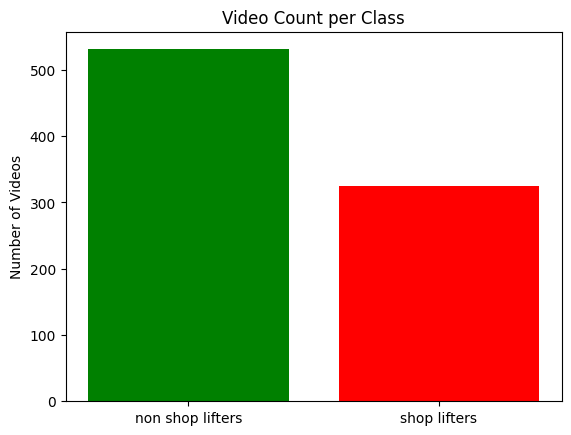

In [4]:
video_counts = []
labels = []

for cls in classes:
    class_path = os.path.join(base_dir, cls)
    count = len([f for f in os.listdir(class_path) if f.endswith('.mp4')])
    video_counts.append(count)
    labels.append(cls)

plt.bar(labels, video_counts, color=['green', 'red'])
plt.title("Video Count per Class")
plt.ylabel("Number of Videos")
plt.show()


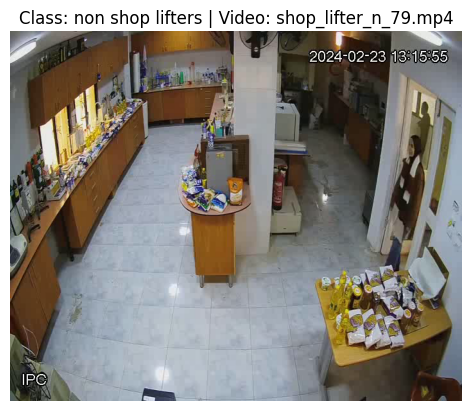

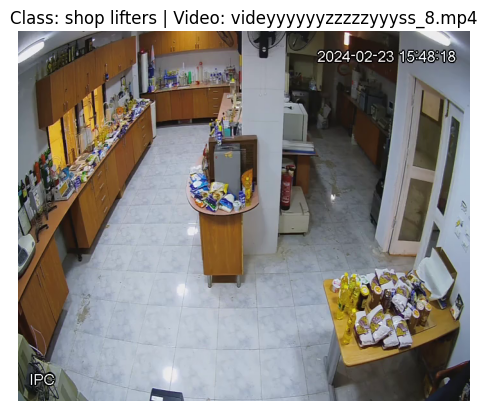

In [5]:
def show_random_video_frame(class_name):
    class_path = os.path.join(base_dir, class_name)
    videos = [f for f in os.listdir(class_path) if f.endswith('.mp4')]

    if not videos:
        print("No videos found.")
        return

    selected_video = random.choice(videos)
    video_path = os.path.join(class_path, selected_video)

    # Read first frame
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    cap.release()

    if ret:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(frame_rgb)
        plt.title(f"Class: {class_name} | Video: {selected_video}")
        plt.axis('off')
        plt.show()
    else:
        print("Failed to read frame from video.")

# Show one sample from each class
for cls in classes:
    show_random_video_frame(cls)


# Data Generator

In [6]:
def format_frames(frame, output_size):
    frame = tf.image.convert_image_dtype(frame, tf.float32)  # Normalize pixel values to [0,1]
    frame = tf.image.resize_with_pad(frame, *output_size)    # Resize with padding to maintain aspect ratio
    return frame

def frames_from_video_file(video_path, n_frames, output_size=(224,224), frame_step=15):
    result = []
    src = cv2.VideoCapture(str(video_path))
    video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

    need_length = 1 + (n_frames - 1) * frame_step

    if need_length > video_length:
        start = 0
    else:
        max_start = video_length - need_length
        start = random.randint(0, int(max_start))

    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    ret, frame = src.read()
    result.append(format_frames(frame, output_size))

    for _ in range(n_frames - 1):
        for _ in range(frame_step):
            ret, frame = src.read()
        if ret:
            frame = format_frames(frame, output_size)
            result.append(frame)
        else:
            result.append(np.zeros_like(result[0]))
    src.release()
    result = np.array(result)[..., [2, 1, 0]]  # BGR to RGB
    return result

In [7]:
class FrameGenerator: # Used to create a stream of frame sequences with labels.
    def __init__(self, path, n_frames, shuffle=False):
        self.path = path
        self.n_frames = n_frames
        self.shuffle = shuffle
        self.class_names = sorted([p.name for p in self.path.iterdir() if p.is_dir()])
        self.class_ids_for_name = {name: idx for idx, name in enumerate(self.class_names)}

    def get_files_and_class_names(self):
        video_paths = list(self.path.glob("*/*.mp4"))
        classes = [p.parent.name for p in video_paths]
        return video_paths, classes

    def __call__(self):
        video_paths, classes = self.get_files_and_class_names()
        pairs = list(zip(video_paths, classes))
        if self.shuffle:
            random.shuffle(pairs)

        for path, class_name in pairs:
            video_frames = frames_from_video_file(path, self.n_frames)
            label = self.class_ids_for_name[class_name]
            yield video_frames, label

In [8]:
# ------------------ Dataset Split ------------------
# We'll manually split data into train/val/test folders

def prepare_split(source_dir, split_dir, splits=(0.7, 0.2, 0.1)):
    # Create the root split directory if not exists
    if not split_dir.exists():
        split_dir.mkdir(parents=True, exist_ok=True)
    else:
        print(f"{split_dir} already exists. Skipping split.")
        return

    for class_dir in source_dir.iterdir():
        if class_dir.is_dir():
            videos = list(class_dir.glob("*.mp4"))
            random.shuffle(videos)

            n = len(videos)
            train_end = int(n * splits[0])
            val_end = train_end + int(n * splits[1])

            split_names = ['train', 'val', 'test']
            split_ranges = [videos[:train_end], videos[train_end:val_end], videos[val_end:]]

            for split_name, video_list in zip(split_names, split_ranges):
                split_class_dir = split_dir / split_name / class_dir.name
                split_class_dir.mkdir(parents=True, exist_ok=True)  
                for v in video_list:
                    target = split_class_dir / v.name
                    if not target.exists():
                        shutil.copy(v, target) 



In [9]:
# Prepare data
split_root = Path("/kaggle/working/Shop_DataSet_split")
prepare_split(Path(base_dir), split_root)

# Create datasets
frame_shape = (n_frames, 224, 224, 3)

# Create datasets
train_ds = tf.data.Dataset.from_generator(
    FrameGenerator(split_root / 'train', n_frames, shuffle=True),
    output_signature=(
        tf.TensorSpec(shape=frame_shape, dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
)

val_ds = tf.data.Dataset.from_generator(
    FrameGenerator(split_root / 'val', n_frames),
    output_signature=(
        tf.TensorSpec(shape=frame_shape, dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
)

test_ds = tf.data.Dataset.from_generator(
    FrameGenerator(split_root / 'test', n_frames),
    output_signature=(
        tf.TensorSpec(shape=frame_shape, dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
)

I0000 00:00:1754316009.739698      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754316009.740477      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [10]:
# Batch
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

In [11]:
videos,labels = next(iter(train_ds))
print(f'videos: {videos.shape}')
print(f'labels: {labels.shape}')
print(f'labels: {labels}')

videos: (8, 10, 224, 224, 3)
labels: (8,)
labels: [0 1 0 0 0 1 0 0]


# **Modeling

In [12]:
from tensorflow import keras
from tensorflow.keras import layers
import einops

# ---------- CONSTANTS ----------
HEIGHT, WIDTH = 224, 224
NUM_CLASSES = 1  # Binary classification (0 = no theft, 1 = theft)

# ---------- LAYERS ----------
class Conv2Plus1D(keras.layers.Layer):
    def __init__(self, filters, kernel_size, padding):
        super().__init__()
        self.seq = keras.Sequential([
            layers.Conv3D(filters=filters,
                          kernel_size=(1, kernel_size[1], kernel_size[2]),
                          padding=padding),
            layers.Conv3D(filters=filters,
                          kernel_size=(kernel_size[0], 1, 1),
                          padding=padding)
        ])
    def call(self, x):
        return self.seq(x)

class ResidualMain(keras.layers.Layer):
    def __init__(self, filters, kernel_size):
        super().__init__()
        self.seq = keras.Sequential([
            Conv2Plus1D(filters=filters, kernel_size=kernel_size, padding='same'),
            layers.LayerNormalization(),
            layers.ReLU(),
            Conv2Plus1D(filters=filters, kernel_size=kernel_size, padding='same'),
            layers.LayerNormalization()
        ])
    def call(self, x):
        return self.seq(x)

class Project(keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.seq = keras.Sequential([
            layers.Dense(units),
            layers.LayerNormalization()
        ])
    def call(self, x):
        return self.seq(x)

class ResizeVideo(keras.layers.Layer):
    def __init__(self, height, width):
        super().__init__()
        self.height = height
        self.width = width
        self.resizing_layer = layers.Resizing(self.height, self.width)
    def call(self, video):
        old_shape = einops.parse_shape(video, 'b t h w c')
        images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
        images = self.resizing_layer(images)
        videos = einops.rearrange(images, '(b t) h w c -> b t h w c', t=old_shape['t'])
        return videos

def add_residual_block(input, filters, kernel_size):
    out = ResidualMain(filters, kernel_size)(input)
    res = input
    if out.shape[-1] != input.shape[-1]:
        res = Project(out.shape[-1])(res)
    return layers.add([res, out])


In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Custom LSTMCell (from scratch)
class CustomLSTMCell(tf.keras.layers.Layer):
    def __init__(self, units):
        super(CustomLSTMCell, self).__init__()
        self.units = units

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.W_f = self.add_weight(shape=(input_dim + self.units, self.units), initializer='glorot_uniform', name='W_f')
        self.b_f = self.add_weight(shape=(self.units,), initializer='zeros', name='b_f')

        self.W_i = self.add_weight(shape=(input_dim + self.units, self.units), initializer='glorot_uniform', name='W_i')
        self.b_i = self.add_weight(shape=(self.units,), initializer='zeros', name='b_i')

        self.W_c = self.add_weight(shape=(input_dim + self.units, self.units), initializer='glorot_uniform', name='W_c')
        self.b_c = self.add_weight(shape=(self.units,), initializer='zeros', name='b_c')

        self.W_o = self.add_weight(shape=(input_dim + self.units, self.units), initializer='glorot_uniform', name='W_o')
        self.b_o = self.add_weight(shape=(self.units,), initializer='zeros', name='b_o')

    def call(self, x, states):
        h_prev, c_prev = states
        combined = tf.concat([x, h_prev], axis=-1)

        f = tf.sigmoid(tf.matmul(combined, self.W_f) + self.b_f)
        i = tf.sigmoid(tf.matmul(combined, self.W_i) + self.b_i)
        c_hat = tf.tanh(tf.matmul(combined, self.W_c) + self.b_c)
        c = f * c_prev + i * c_hat
        o = tf.sigmoid(tf.matmul(combined, self.W_o) + self.b_o)
        h = o * tf.tanh(c)

        return h, [h, c]

# Custom LSTM layer using the above cell
class CustomLSTM(tf.keras.layers.Layer):
    def __init__(self, units):
        super(CustomLSTM, self).__init__()
        self.units = units
        self.cell = CustomLSTMCell(units)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        time_steps = tf.shape(inputs)[1]
        h = tf.zeros((batch_size, self.units))
        c = tf.zeros((batch_size, self.units))

        for t in range(inputs.shape[1]):
            h, [h, c] = self.cell(inputs[:, t], [h, c])

        return h



In [14]:
# ---------- MODEL ----------
def build_cnn_lstm(input_shape=(10, 224, 224, 3), num_classes=1):
    inputs = layers.Input(shape=input_shape)

    # CNN feature extraction per frame
    x = layers.TimeDistributed(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))(inputs)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
    x = layers.TimeDistributed(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))(x)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
    x = layers.TimeDistributed(layers.Flatten())(x)  # (batch, n_frames, features)

    # Custom LSTM
    x = CustomLSTM(64)(x)
    x = layers.Dropout(0.5)(x)

    # Output
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)
    return models.Model(inputs, outputs)


In [15]:
def get_model():
    model = build_cnn_lstm()
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        metrics=['accuracy']
    )
    return model

model = get_model()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True)
]

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 224, 224,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 224, 224,   │           896 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 112, 112,   │             0 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 10, 112, 112,   │        18,496 │
│ (TimeDistributed)               │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 10, 56, 56, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 10, 200704)     │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_lstm (CustomLSTM)        │ (None, 64)             │    51,396,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,416,321 (196.14 MB)

 Trainable params: 51,416,321 (196.14 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks
)


Epoch 1/50


I0000 00:00:1754316023.691252     112 service.cc:148] XLA service 0x7d585c0edc20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754316023.692343     112 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1754316023.692366     112 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1754316025.232009     112 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1754316031.543034     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


     75/Unknown 140s 2s/step - accuracy: 0.5536 - loss: 0.7100

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


75/75 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - accuracy: 0.5541 - loss: 0.7095 - val_accuracy: 0.6235 - val_loss: 0.6394
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.6208 - loss: 0.6258 - val_accuracy: 0.8647 - val_loss: 0.4379
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.8745 - loss: 0.4047 - val_accuracy: 0.7059 - val_loss: 0.4758
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.8398 - loss: 0.3445 - val_accuracy: 0.8765 - val_loss: 0.2018
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.9433 - loss: 0.1980 - val_accuracy: 0.9235 - val_loss: 0.1931
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.9737 - loss: 0.1291 - val_accuracy: 0.9941 - val_loss: 0.1363
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.9669 - loss: 0.1378 - val_accuracy: 0.9882 - val_loss: 0.0795
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.9846 - loss: 0.0924 - val_accuracy: 1.0000 - val_loss: 0.

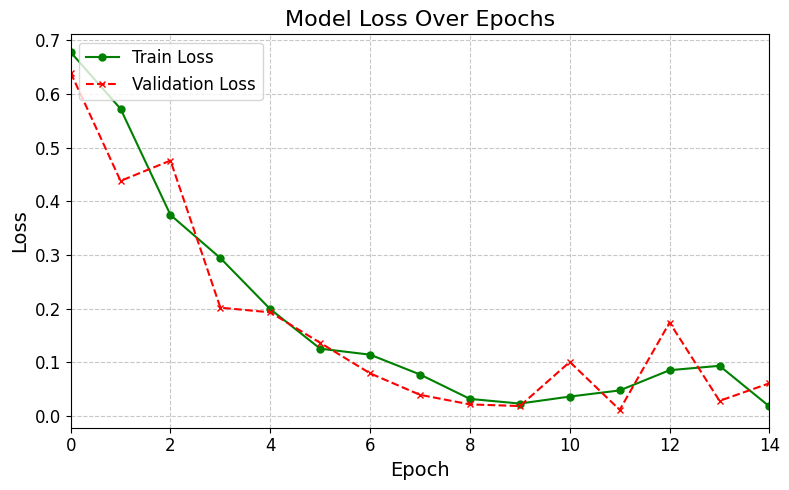

In [17]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], color='green', linestyle='-', marker='o', markersize=5, label='Train Loss')
plt.plot(history.history['val_loss'], color='red', linestyle='--', marker='x', markersize=5, label='Validation Loss')

plt.title('Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)

plt.legend(loc='upper left', fontsize=12)

plt.xlim(0, len(history.history['loss']) - 1)

plt.tight_layout()
plt.show()


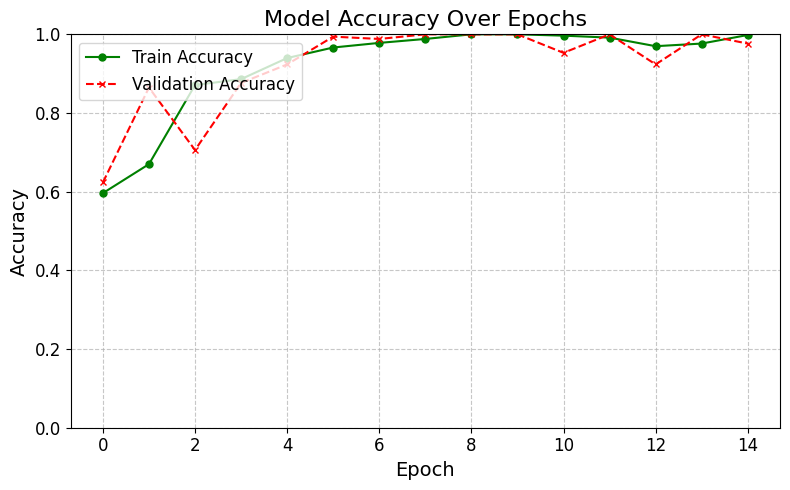

In [18]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], color='green', linestyle='-', marker='o', markersize=5, label='Train Accuracy')
plt.plot(history.history['val_accuracy'], color='red', linestyle='--', marker='x', markersize=5, label='Validation Accuracy')

plt.title('Model Accuracy Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)

plt.legend(loc='upper left', fontsize=12)

plt.ylim(0, 1)

plt.tight_layout()
plt.show()


# Save Model

In [19]:
model.save("cnn_lstm_model.h5")  


# Model Evaluation

In [21]:
loss, accuracy = model.evaluate(test_ds)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 1.0000 - loss: 0.0080
Loss: 0.010854526422917843
Accuracy: 1.0


In [23]:
predictions=model.predict(test_ds)

11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step


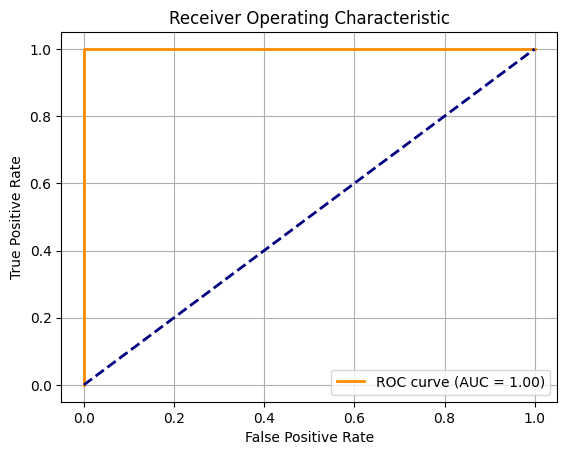

In [24]:
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = predictions.ravel()

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.grid(True)
plt.show()


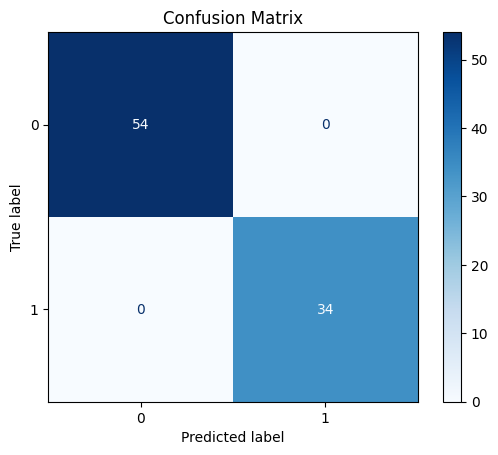

In [25]:
y_pred_labels = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_true, y_pred_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [28]:
print(classification_report(y_true, y_pred_labels, target_names=["No Theft", "Theft"]))

              precision    recall  f1-score   support

    No Theft       1.00      1.00      1.00        54
       Theft       1.00      1.00      1.00        34

    accuracy                           1.00        88
   macro avg       1.00      1.00      1.00        88
weighted avg       1.00      1.00      1.00        88



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


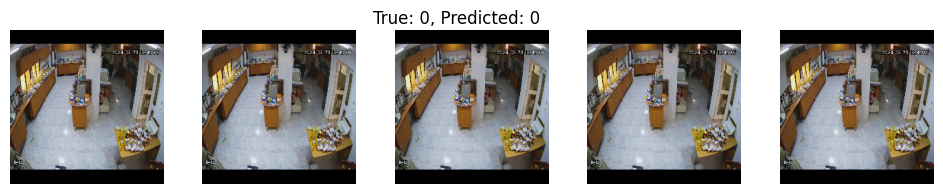

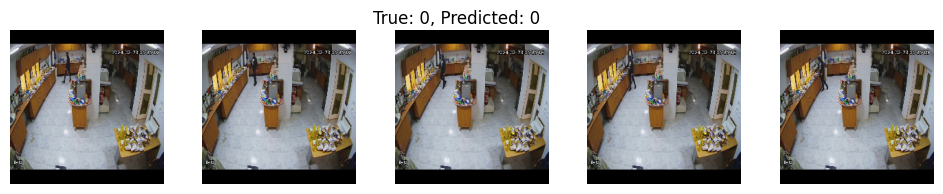

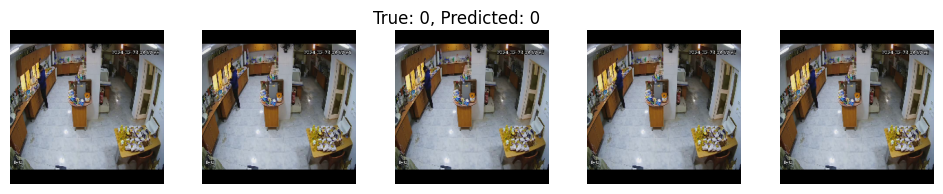

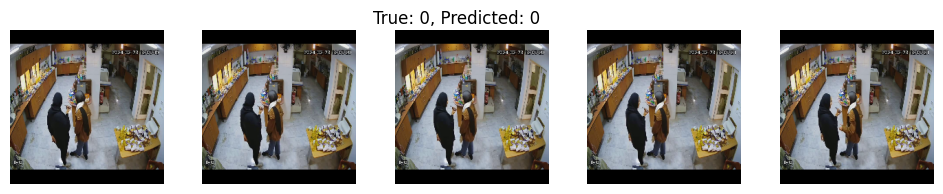

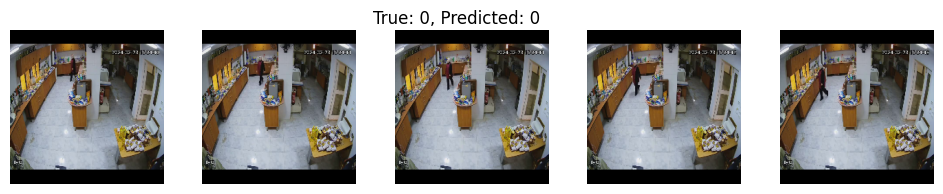

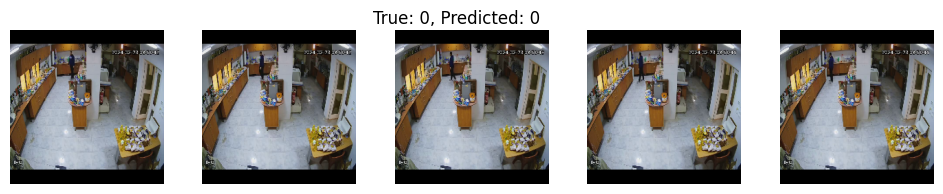

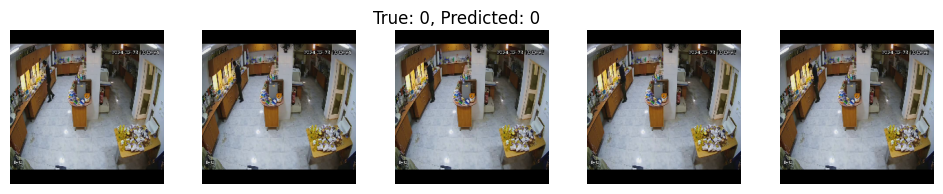

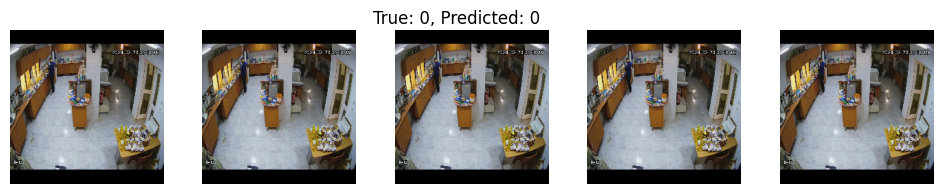

In [27]:
for videos, labels in test_ds.take(1):  
    preds = (model.predict(videos) > 0.5).astype(int)
    for i in range(len(videos)):
        plt.figure(figsize=(12, 2))
        for t in range(min(5, videos.shape[1])):  
            plt.subplot(1, 5, t+1)
            plt.imshow(videos[i][t])
            plt.axis("off")
        plt.suptitle(f"True: {labels[i].numpy()}, Predicted: {preds[i][0]}")
        plt.show()
